Copyright by Arjun Sarkar Research Group Applied Systems Biology - Head: Prof. Dr. Marc Thilo Figge https://www.leibniz-hki.de/en/applied-systems-biology.html HKI-Center for Systems Biology of Infection Leibniz Institute for Natural Product Research and Infection Biology - Hans Knöll Insitute (HKI) Adolf-Reichwein-Straße 23, 07745 Jena, Germany

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2 as cv
from sklearn.model_selection import train_test_split

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

strategy = tf.distribute.MirroredStrategy(["GPU:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [3]:
NUM_FEATURES = 1280
MAX_SEQ_LENGTH = 40
IMG_SIZE = 224

EPOCHS = 500

In [4]:
df = pd.read_csv('Labels.csv')
df = df.rename(columns={'Inefction_type':'infection'})
df.head()

,Video_Num,infection,Patient,Patient_id
0,1,ca,1,20180220
1,2,cg,1,20180220
2,3,mock,1,20180220
3,4,ca,2,20180315
4,5,cg,2,20180315


In [5]:
test = df[(df['Patient']==7)]
test

,Video_Num,infection,Patient,Patient_id
9,18,ca,7,20180914
10,19,cg,7,20180914
11,20,mock,7,20180914


In [6]:
train = pd.concat([df, test]).drop_duplicates(keep=False)
train

,Video_Num,infection,Patient,Patient_id
0,1,ca,1,20180220
1,2,cg,1,20180220
2,3,mock,1,20180220
3,4,ca,2,20180315
4,5,cg,2,20180315
5,6,mock,2,20180315
6,13,ca,5,20180409
7,14,cg,5,20180409
8,15,mock,5,20180409
12,21,ca,8,20180918


In [7]:
def concat_arrays(df):

    full_features = []
    full_labels = []

    for i,item in df.iterrows():
    
        features = np.load(f'/asbdata/Arjun/Bloodi/Split_numpy/videos/{item[0]}_features.npy')
        labels = np.load(f'/asbdata/Arjun/Bloodi/Split_numpy/labels/{item[0]}_labels.npy')
    
        full_features.extend(features)
        full_labels.extend(labels)
    
    final_features = np.array(full_features)
    final_labels = np.array(full_labels)
    
    return final_features,final_labels

In [8]:
train_data, train_labels = concat_arrays(train)
test_data, test_labels = concat_arrays(test)


print(train_data.shape)
print(train_labels.shape)

print(test_data.shape)
print(test_labels.shape)

(9443, 40, 1280)
(9443, 1)
(1231, 40, 1280)
(1231, 1)


In [9]:
class PositionalEmbedding(layers.Layer):
    
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim
        
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'sequence_length': self.sequence_length,
            'output_dim': self.output_dim
        })
        return config

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask

In [10]:
class TransformerEncoder(layers.Layer):
    
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'dense_dim': self.dense_dim,
            'num_heads': self.num_heads
        })
        return config

    def call(self, inputs, mask=None):
        
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [11]:
with strategy.scope():
    

    def get_compiled_model():
        
        sequence_length = MAX_SEQ_LENGTH
        embed_dim = NUM_FEATURES
        dense_dim = 4
        num_heads = 4
        classes = 3

        inputs = keras.Input(shape=(None, None))
        x = PositionalEmbedding(sequence_length, embed_dim, name="frame_position_embedding")(inputs)
        x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
        x = layers.GlobalMaxPooling1D()(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(classes, activation="softmax")(x)
        model = keras.Model(inputs, outputs)

        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"]
        )
        
        model.summary()
        
        return model

In [12]:
with strategy.scope():
    
    def run_experiment():
        
        filepath = "Transformer_4_split.h5"
        checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, verbose=1)
        stopping = EarlyStopping(monitor='val_loss', patience=30)
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=10,verbose=1,mode='auto')

        model = get_compiled_model()
        history = model.fit(
            train_data,
            train_labels,
            validation_split=0.1,
            epochs=EPOCHS,
            callbacks=[checkpoint,stopping,reduce_lr],
        )

        model.load_weights(filepath)
        _, accuracy = model.evaluate(test_data, test_labels)
        print(f"Test accuracy: {round(accuracy * 100, 2)}%")

        return model

In [13]:
trained_model = run_experiment()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None)]      0         
                                                                 
 frame_position_embedding (P  (None, None, 1280)       51200     
 ositionalEmbedding)                                             
                                                                 
 transformer_layer (Transfor  (None, None, 1280)       26247684  
 merEncoder)                                                     
                                                                 
 global_max_pooling1d (Globa  (None, 1280)             0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                             

/home/asarkar/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/500
262/266 [============================>.] - ETA: 0s - loss: 1.0911 - accuracy: 0.5835
Epoch 1: val_loss improved from inf to 0.78208, saving model to Transformer_4_split.h5
266/266 [==============================] - 9s 21ms/step - loss: 1.0863 - accuracy: 0.5845 - val_loss: 0.7821 - val_accuracy: 0.7365 - lr: 1.0000e-04
Epoch 2/500
261/266 [============================>.] - ETA: 0s - loss: 0.6960 - accuracy: 0.6907
Epoch 2: val_loss improved from 0.78208 to 0.56711, saving model to Transformer_4_split.h5
266/266 [==============================] - 5s 20ms/step - loss: 0.6958 - accuracy: 0.6904 - val_loss: 0.5671 - val_accuracy: 0.7725 - lr: 1.0000e-04
Epoch 3/500
263/266 [============================>.] - ETA: 0s - loss: 0.6030 - accuracy: 0.7360
Epoch 3: val_loss did not improve from 0.56711
266/266 [==============================] - 3s 10ms/step - loss: 0.6040 - accuracy: 0.7352 - val_loss: 0.5936 - val_accuracy: 0.7884 - lr: 1.0000e-04
Epoch 4/500
265/266 [================

Epoch 28/500
260/266 [============================>.] - ETA: 0s - loss: 0.0613 - accuracy: 0.9778
Epoch 28: val_loss did not improve from 0.50032
266/266 [==============================] - 3s 10ms/step - loss: 0.0609 - accuracy: 0.9779 - val_loss: 2.9918 - val_accuracy: 0.7132 - lr: 1.0000e-06
Epoch 29/500
265/266 [============================>.] - ETA: 0s - loss: 0.0652 - accuracy: 0.9762
Epoch 29: val_loss did not improve from 0.50032
266/266 [==============================] - 3s 11ms/step - loss: 0.0656 - accuracy: 0.9759 - val_loss: 3.0754 - val_accuracy: 0.7058 - lr: 1.0000e-06
Epoch 30/500
263/266 [============================>.] - ETA: 0s - loss: 0.0624 - accuracy: 0.9774
Epoch 30: val_loss did not improve from 0.50032
266/266 [==============================] - 3s 10ms/step - loss: 0.0621 - accuracy: 0.9775 - val_loss: 2.9677 - val_accuracy: 0.7143 - lr: 1.0000e-06
Epoch 31/500
262/266 [============================>.] - ETA: 0s - loss: 0.0633 - accuracy: 0.9773
Epoch 31: val_los

In [14]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [15]:
trained_model = tf.keras.models.load_model('Transformer_4_split.h5',custom_objects={'PositionalEmbedding': PositionalEmbedding,
                                                                     'TransformerEncoder':TransformerEncoder})

39/39 [==============================] - 1s 3ms/step


([<matplotlib.axis.YTick at 0x7f2c8c043040>,
 [Text(0, 0, 'ca'), Text(0, 1, 'cg'), Text(0, 2, 'mock')])

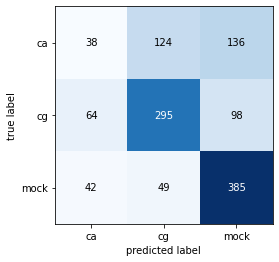

In [16]:
predicted_vals = trained_model.predict(test_data).argmax(axis=1)

labels = ['ca','cg','mock']

matrix = confusion_matrix (test_labels,predicted_vals)
plot_confusion_matrix(matrix, figsize=(4,4))
plt.xticks(range(3),labels, fontsize=10)
plt.yticks(range(3),labels, fontsize=10)

In [17]:
target_names = ["$\it{C. albicans}$","$\it{C. glabrata}$","Mock"]

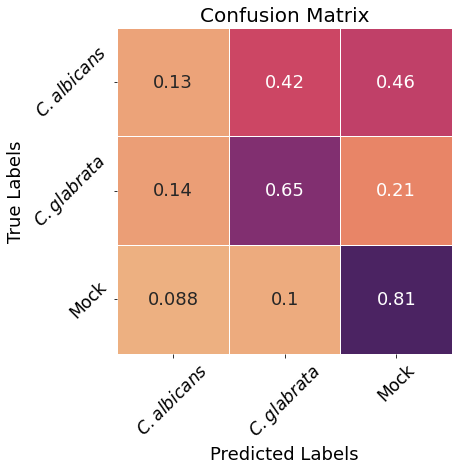

In [18]:
import seaborn as sns

cm = confusion_matrix(test_labels,predicted_vals)
# Normalise
#sns.set(rc={"figure.dpi":200})
cmn = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale = 1.5)
image_cm = sns.heatmap(cmn, cmap="flare",linewidths= 0.5,
            annot=True,xticklabels=target_names, yticklabels=target_names, cbar=0)
plt.ylabel('True Labels', fontsize = 18)
plt.xlabel('Predicted Labels', fontsize = 18)
plt.xticks(rotation = 45, fontsize = 17)
plt.yticks(rotation = 45,fontsize = 17)
plt.title('Confusion Matrix', fontsize=20)
plt.show(block=True)
image_cm.figure.savefig('confusion_matrices_split/4_norm.png',dpi=300,bbox_inches='tight')

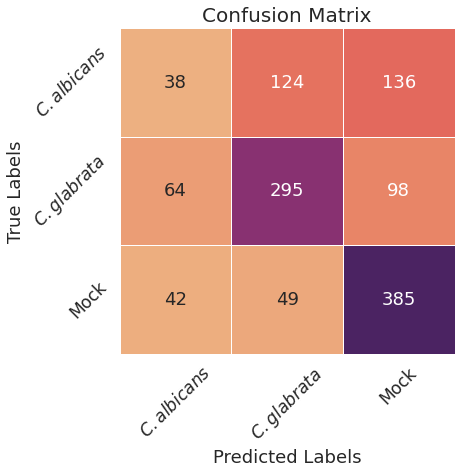

In [19]:
cm = confusion_matrix(test_labels,predicted_vals)
# Normalise
#sns.set(rc={"figure.dpi":200})
cmn = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale = 1.5)
image_cm = sns.heatmap(cm, cmap="flare",linewidths= 0.5,
            annot=True,fmt ='g',xticklabels=target_names, yticklabels=target_names, cbar=0)
plt.ylabel('True Labels', fontsize = 18)
plt.xlabel('Predicted Labels', fontsize = 18)
plt.xticks(rotation = 45, fontsize = 17)
plt.yticks(rotation = 45,fontsize = 17)
plt.title('Confusion Matrix', fontsize=20)
plt.show(block=True)
image_cm.figure.savefig('confusion_matrices_split/4_all.png',dpi=300,bbox_inches='tight')